# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

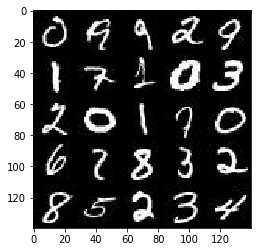

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

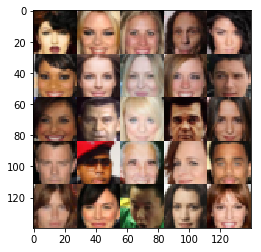

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_img = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learn_rate = tf.placeholder(tf.float32, name='learn_input')

    return real_input_img, z_input, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        #current size 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        # 14*14*64
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        # 7*7*128
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        #4*4*256
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*256)
        # Reshape it to start the convolutional stack - 4x4x256
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x56 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out
    return None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)* (1 - 0.1)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)+0.1))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*0.9))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]


    # Optimize
    with tf.control_dependencies(d_update_ops): 
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print(data_shape)
    input_real, input_z, _ = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z,
                                              data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2
                steps+=1
                #TODO: Train Model
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
#                     gen_samples = sess.run(
#                                    generator(input_z, data_shape[3], is_train=False),
#                                    feed_dict={input_z: sample_z})
#                     samples.append(gen_samples)
#                     _ = view_samples(-1, samples, 5, 10, figsize=figsize)
#                     plt.show()
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/15... Discriminator Loss: 3.8406... Generator Loss: 11.6371
Epoch 1/15... Discriminator Loss: 0.8069... Generator Loss: 1.6311
Epoch 1/15... Discriminator Loss: 2.3312... Generator Loss: 0.3352
Epoch 1/15... Discriminator Loss: 1.2959... Generator Loss: 0.6092
Epoch 1/15... Discriminator Loss: 1.9911... Generator Loss: 0.4449
Epoch 1/15... Discriminator Loss: 1.0627... Generator Loss: 0.8676
Epoch 1/15... Discriminator Loss: 0.9197... Generator Loss: 0.9833
Epoch 1/15... Discriminator Loss: 0.9527... Generator Loss: 1.3715
Epoch 1/15... Discriminator Loss: 0.9412... Generator Loss: 0.9752
Epoch 1/15... Discriminator Loss: 1.8513... Generator Loss: 0.4043


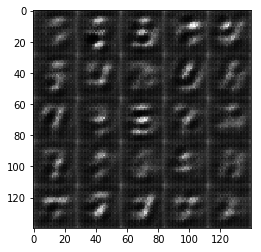

Epoch 1/15... Discriminator Loss: 1.0536... Generator Loss: 2.2348
Epoch 1/15... Discriminator Loss: 1.4178... Generator Loss: 2.1486
Epoch 1/15... Discriminator Loss: 0.9794... Generator Loss: 1.4055
Epoch 1/15... Discriminator Loss: 1.1865... Generator Loss: 0.7194
Epoch 1/15... Discriminator Loss: 1.0256... Generator Loss: 0.9631
Epoch 1/15... Discriminator Loss: 1.2190... Generator Loss: 1.8455
Epoch 1/15... Discriminator Loss: 1.0031... Generator Loss: 0.9569
Epoch 1/15... Discriminator Loss: 1.4263... Generator Loss: 1.4920
Epoch 1/15... Discriminator Loss: 0.9742... Generator Loss: 1.0141
Epoch 1/15... Discriminator Loss: 1.1048... Generator Loss: 1.3988


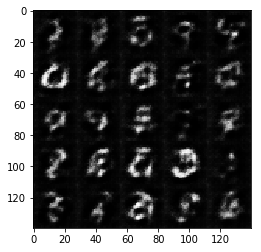

Epoch 1/15... Discriminator Loss: 1.0515... Generator Loss: 1.1268
Epoch 1/15... Discriminator Loss: 1.0321... Generator Loss: 1.1738
Epoch 1/15... Discriminator Loss: 1.0029... Generator Loss: 0.9673
Epoch 2/15... Discriminator Loss: 1.0604... Generator Loss: 0.8367
Epoch 2/15... Discriminator Loss: 1.4734... Generator Loss: 2.5366
Epoch 2/15... Discriminator Loss: 1.1345... Generator Loss: 0.7460
Epoch 2/15... Discriminator Loss: 1.0869... Generator Loss: 0.8646
Epoch 2/15... Discriminator Loss: 1.2332... Generator Loss: 0.5990
Epoch 2/15... Discriminator Loss: 0.9722... Generator Loss: 1.5377
Epoch 2/15... Discriminator Loss: 1.5105... Generator Loss: 0.4867


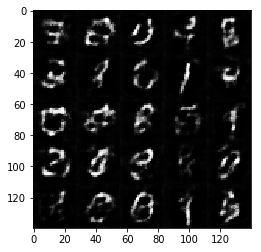

Epoch 2/15... Discriminator Loss: 1.0818... Generator Loss: 1.2888
Epoch 2/15... Discriminator Loss: 1.3851... Generator Loss: 2.1719
Epoch 2/15... Discriminator Loss: 0.9810... Generator Loss: 1.3224
Epoch 2/15... Discriminator Loss: 1.0549... Generator Loss: 0.8725
Epoch 2/15... Discriminator Loss: 1.0685... Generator Loss: 0.7814
Epoch 2/15... Discriminator Loss: 1.1054... Generator Loss: 0.7542
Epoch 2/15... Discriminator Loss: 1.0786... Generator Loss: 1.0224
Epoch 2/15... Discriminator Loss: 1.1934... Generator Loss: 1.6990
Epoch 2/15... Discriminator Loss: 1.0095... Generator Loss: 1.1713
Epoch 2/15... Discriminator Loss: 1.0587... Generator Loss: 0.8093


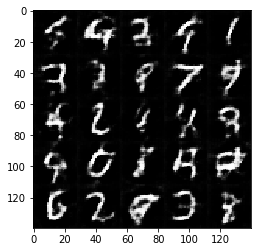

Epoch 2/15... Discriminator Loss: 1.0801... Generator Loss: 0.9426
Epoch 2/15... Discriminator Loss: 1.3562... Generator Loss: 1.9146
Epoch 2/15... Discriminator Loss: 1.2682... Generator Loss: 0.5834
Epoch 2/15... Discriminator Loss: 1.0583... Generator Loss: 1.2236
Epoch 2/15... Discriminator Loss: 1.1893... Generator Loss: 1.7383
Epoch 2/15... Discriminator Loss: 1.3368... Generator Loss: 0.5319
Epoch 3/15... Discriminator Loss: 1.0242... Generator Loss: 1.4093
Epoch 3/15... Discriminator Loss: 1.0053... Generator Loss: 1.2808
Epoch 3/15... Discriminator Loss: 1.4411... Generator Loss: 1.7592
Epoch 3/15... Discriminator Loss: 1.0626... Generator Loss: 0.9225


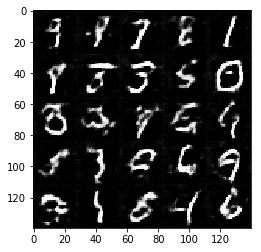

Epoch 3/15... Discriminator Loss: 1.0980... Generator Loss: 0.9909
Epoch 3/15... Discriminator Loss: 1.2451... Generator Loss: 0.6006
Epoch 3/15... Discriminator Loss: 1.0277... Generator Loss: 1.2693
Epoch 3/15... Discriminator Loss: 1.0914... Generator Loss: 0.7793
Epoch 3/15... Discriminator Loss: 1.0157... Generator Loss: 0.9895
Epoch 3/15... Discriminator Loss: 1.2325... Generator Loss: 0.6139
Epoch 3/15... Discriminator Loss: 1.0185... Generator Loss: 0.8828
Epoch 3/15... Discriminator Loss: 1.4955... Generator Loss: 0.5082
Epoch 3/15... Discriminator Loss: 1.2210... Generator Loss: 0.8609
Epoch 3/15... Discriminator Loss: 1.1728... Generator Loss: 0.9470


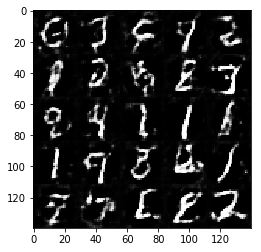

Epoch 3/15... Discriminator Loss: 1.4396... Generator Loss: 0.5012
Epoch 3/15... Discriminator Loss: 1.0351... Generator Loss: 0.9071
Epoch 3/15... Discriminator Loss: 1.0413... Generator Loss: 0.7844
Epoch 3/15... Discriminator Loss: 1.0997... Generator Loss: 0.6997
Epoch 3/15... Discriminator Loss: 0.9746... Generator Loss: 1.2561
Epoch 3/15... Discriminator Loss: 1.0314... Generator Loss: 0.7670
Epoch 3/15... Discriminator Loss: 1.2978... Generator Loss: 1.8552
Epoch 3/15... Discriminator Loss: 1.3633... Generator Loss: 0.5451
Epoch 3/15... Discriminator Loss: 1.0919... Generator Loss: 0.7473
Epoch 3/15... Discriminator Loss: 0.9506... Generator Loss: 1.3034


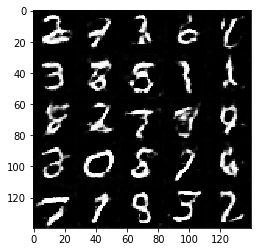

Epoch 4/15... Discriminator Loss: 1.7643... Generator Loss: 2.4181
Epoch 4/15... Discriminator Loss: 1.0457... Generator Loss: 0.8302
Epoch 4/15... Discriminator Loss: 0.9791... Generator Loss: 0.8475
Epoch 4/15... Discriminator Loss: 1.4603... Generator Loss: 0.4953


KeyboardInterrupt: 

In [14]:
batch_size = 256
z_dim = 100
learning_rate = 0.0007
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 15

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

(202599, 28, 28, 3)
Epoch 1/1... Discriminator Loss: 2.3877... Generator Loss: 0.4460
Epoch 1/1... Discriminator Loss: 2.0688... Generator Loss: 0.3985
Epoch 1/1... Discriminator Loss: 0.8285... Generator Loss: 1.6981
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.7662
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 2.4989
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.5935... Generator Loss: 0.4448
Epoch 1/1... Discriminator Loss: 1.1702... Generator Loss: 0.9733


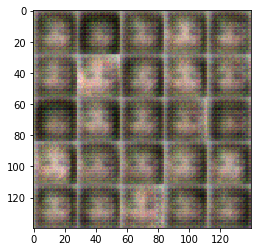

Epoch 1/1... Discriminator Loss: 1.1850... Generator Loss: 0.7284
Epoch 1/1... Discriminator Loss: 1.5344... Generator Loss: 0.4724
Epoch 1/1... Discriminator Loss: 1.2068... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 2.1983
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.0863... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 2.0250... Generator Loss: 0.3645
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.6043


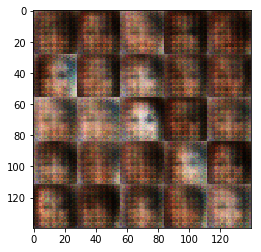

Epoch 1/1... Discriminator Loss: 1.7707... Generator Loss: 0.4002
Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.6224... Generator Loss: 0.4127
Epoch 1/1... Discriminator Loss: 1.7755... Generator Loss: 0.3969
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.4489
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.4653
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.5705
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.5305
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.0362... Generator Loss: 0.7660


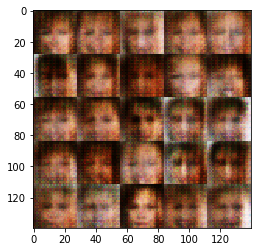

Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.1175
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 1.2766
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.7370
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.0752... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.4769
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 1.1971
Epoch 1/1... Discriminator Loss: 1.6163... Generator Loss: 1.9108


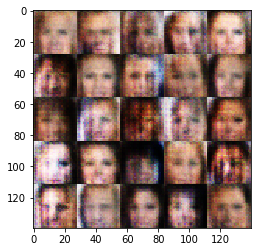

Epoch 1/1... Discriminator Loss: 1.1876... Generator Loss: 0.8677
Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 1.1752... Generator Loss: 0.8620
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 1.2258
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.9419
Epoch 1/1... Discriminator Loss: 1.3501... Generator Loss: 1.4754
Epoch 1/1... Discriminator Loss: 1.4869... Generator Loss: 0.4643
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.6335


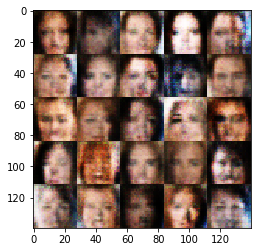

Epoch 1/1... Discriminator Loss: 1.6390... Generator Loss: 1.8470
Epoch 1/1... Discriminator Loss: 1.2643... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 1.1826
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.8526
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 1.1185
Epoch 1/1... Discriminator Loss: 1.9484... Generator Loss: 0.3570
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 1.1328... Generator Loss: 1.0235


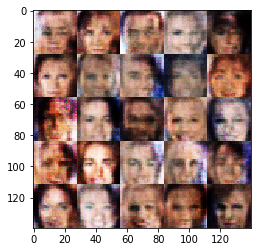

Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 1.2603
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.9891
Epoch 1/1... Discriminator Loss: 1.1736... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.6741... Generator Loss: 0.4126
Epoch 1/1... Discriminator Loss: 1.5418... Generator Loss: 1.2907
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 1.0707
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 1.5720
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.9352


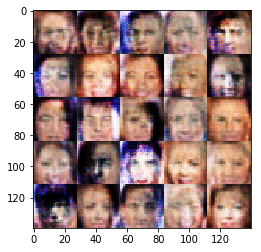

Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.4786
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.7695... Generator Loss: 0.3832
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.0555... Generator Loss: 0.9947
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.2328... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 1.5194


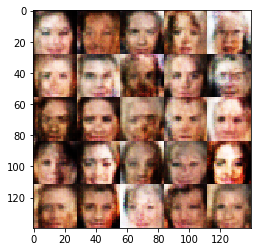

Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.5789... Generator Loss: 1.2186
Epoch 1/1... Discriminator Loss: 1.1245... Generator Loss: 0.9005
Epoch 1/1... Discriminator Loss: 1.2631... Generator Loss: 1.1554
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.5591
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.4801... Generator Loss: 1.3653
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.5914


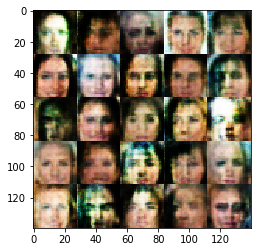

Epoch 1/1... Discriminator Loss: 1.9230... Generator Loss: 2.0649
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.1047... Generator Loss: 1.6283
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.6475
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.5109
Epoch 1/1... Discriminator Loss: 1.2213... Generator Loss: 0.6511
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.6611


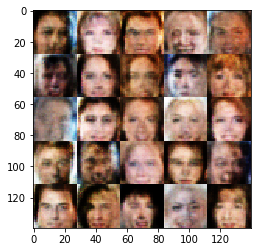

Epoch 1/1... Discriminator Loss: 0.9456... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.2957
Epoch 1/1... Discriminator Loss: 2.0925... Generator Loss: 1.6420
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.8375
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.6961
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 1.2508
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.6038


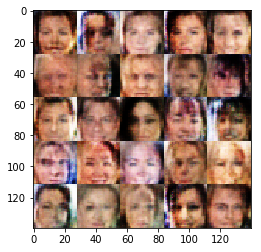

Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.2560... Generator Loss: 0.6392
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.8455
Epoch 1/1... Discriminator Loss: 1.6058... Generator Loss: 1.5766
Epoch 1/1... Discriminator Loss: 1.7428... Generator Loss: 0.3937
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 1.4126
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.4749


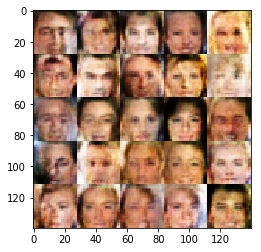

Epoch 1/1... Discriminator Loss: 1.5507... Generator Loss: 1.4986
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.9594
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.6072... Generator Loss: 1.4715
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.5410
Epoch 1/1... Discriminator Loss: 1.5714... Generator Loss: 1.3850
Epoch 1/1... Discriminator Loss: 1.5615... Generator Loss: 0.4384
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.6876


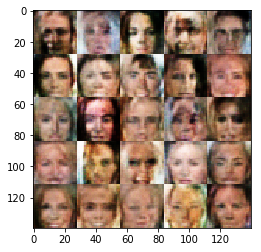

Epoch 1/1... Discriminator Loss: 1.0276... Generator Loss: 0.9492
Epoch 1/1... Discriminator Loss: 1.0690... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.4833
Epoch 1/1... Discriminator Loss: 1.5640... Generator Loss: 0.4457
Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 0.9299
Epoch 1/1... Discriminator Loss: 0.9686... Generator Loss: 1.3177
Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.1497
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 1.0312
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.9518


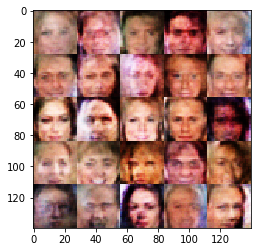

Epoch 1/1... Discriminator Loss: 1.4594... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 0.9620
Epoch 1/1... Discriminator Loss: 1.6843... Generator Loss: 0.4136
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 1.2964
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 1.6166... Generator Loss: 0.4246
Epoch 1/1... Discriminator Loss: 1.0726... Generator Loss: 1.1184
Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.0593
Epoch 1/1... Discriminator Loss: 1.6452... Generator Loss: 0.4176


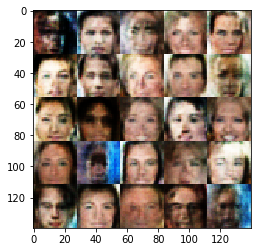

Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.9382
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 1.0311
Epoch 1/1... Discriminator Loss: 1.3493... Generator Loss: 1.1023
Epoch 1/1... Discriminator Loss: 1.6139... Generator Loss: 1.8437
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.1641... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.5924


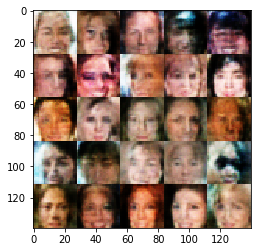

Epoch 1/1... Discriminator Loss: 1.6009... Generator Loss: 0.4215
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 1.7084
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 1.3405
Epoch 1/1... Discriminator Loss: 1.0692... Generator Loss: 1.3330
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.5146
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 1.3707
Epoch 1/1... Discriminator Loss: 1.0599... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.4979
Epoch 1/1... Discriminator Loss: 1.3457... Generator Loss: 0.5246
Epoch 1/1... Discriminator Loss: 1.1656... Generator Loss: 0.6486


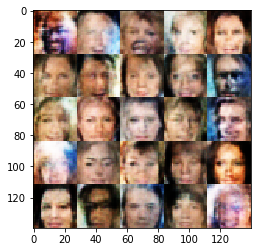

Epoch 1/1... Discriminator Loss: 1.6688... Generator Loss: 0.4072
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 1.4137
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 1.2874
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 1.5648... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.6098


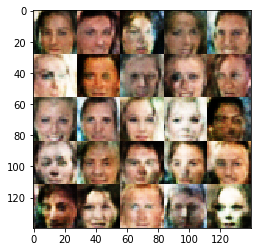

Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 1.0842
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.5281
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.5652
Epoch 1/1... Discriminator Loss: 1.0571... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.3108... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.6459... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.2307
Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 1.4011
Epoch 1/1... Discriminator Loss: 1.7149... Generator Loss: 1.6142
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.4918


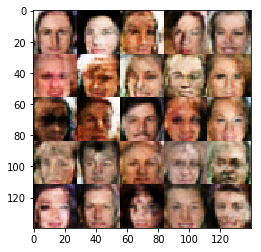

Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.4899... Generator Loss: 0.4544
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.0095
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.4679... Generator Loss: 1.4397


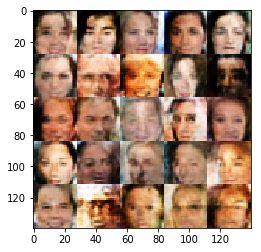

Epoch 1/1... Discriminator Loss: 0.8508... Generator Loss: 1.2507
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 1.4166
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 1.0090
Epoch 1/1... Discriminator Loss: 1.5104... Generator Loss: 0.4466
Epoch 1/1... Discriminator Loss: 1.9624... Generator Loss: 1.5773
Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 1.3484
Epoch 1/1... Discriminator Loss: 1.0078... Generator Loss: 1.3350
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.2106


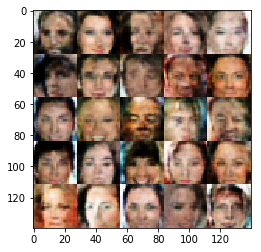

Epoch 1/1... Discriminator Loss: 1.2187... Generator Loss: 1.4152
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 0.9337
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 2.6863
Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 1.2149
Epoch 1/1... Discriminator Loss: 0.9457... Generator Loss: 1.2605
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.5379... Generator Loss: 0.4567
Epoch 1/1... Discriminator Loss: 1.6810... Generator Loss: 0.3993
Epoch 1/1... Discriminator Loss: 0.7821... Generator Loss: 1.3567
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 1.7237


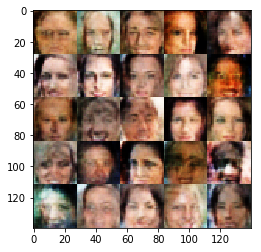

Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.1138
Epoch 1/1... Discriminator Loss: 1.1642... Generator Loss: 1.8805
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 2.4132
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 0.9644... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.3861... Generator Loss: 0.4889
Epoch 1/1... Discriminator Loss: 1.4627... Generator Loss: 0.4724


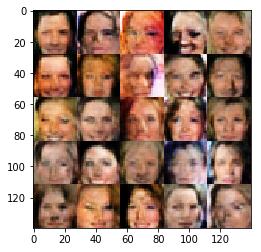

Epoch 1/1... Discriminator Loss: 0.9398... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.6711... Generator Loss: 0.4056
Epoch 1/1... Discriminator Loss: 1.0073... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.4546
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.9397... Generator Loss: 0.3601
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.5193


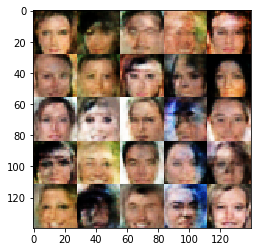

Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.4862
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 1.6131
Epoch 1/1... Discriminator Loss: 0.8537... Generator Loss: 1.6264
Epoch 1/1... Discriminator Loss: 1.7178... Generator Loss: 0.3947
Epoch 1/1... Discriminator Loss: 0.9533... Generator Loss: 1.8927
Epoch 1/1... Discriminator Loss: 1.7758... Generator Loss: 2.2339
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 1.6322
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 1.6322
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 0.4592
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.5074


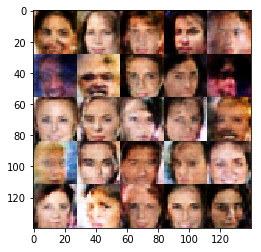

Epoch 1/1... Discriminator Loss: 0.7965... Generator Loss: 1.4066
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 2.4543
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.3733
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 1.6603
Epoch 1/1... Discriminator Loss: 1.0057... Generator Loss: 1.2307
Epoch 1/1... Discriminator Loss: 1.2067... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 0.9448... Generator Loss: 0.8717
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 1.1409


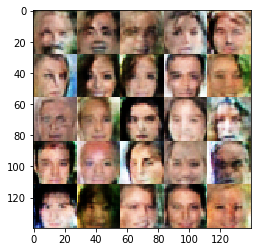

Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 1.8320
Epoch 1/1... Discriminator Loss: 1.0939... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.1396... Generator Loss: 1.7358
Epoch 1/1... Discriminator Loss: 0.7823... Generator Loss: 1.7018
Epoch 1/1... Discriminator Loss: 1.5130... Generator Loss: 2.0526
Epoch 1/1... Discriminator Loss: 1.0511... Generator Loss: 1.0294
Epoch 1/1... Discriminator Loss: 1.2092... Generator Loss: 1.3782
Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 1.6560
Epoch 1/1... Discriminator Loss: 0.7679... Generator Loss: 1.3647
Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.5423


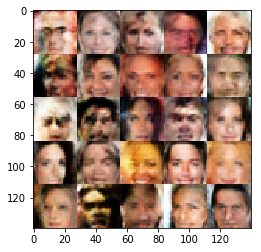

Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.7288
Epoch 1/1... Discriminator Loss: 1.0325... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 0.8378... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 1.5977... Generator Loss: 2.3587
Epoch 1/1... Discriminator Loss: 1.7788... Generator Loss: 0.3791
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 1.8619
Epoch 1/1... Discriminator Loss: 0.9204... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 0.7904... Generator Loss: 1.1502
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.5601


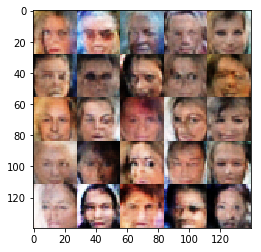

Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.4558
Epoch 1/1... Discriminator Loss: 1.0824... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 0.9391
Epoch 1/1... Discriminator Loss: 1.0570... Generator Loss: 1.5249
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 2.0473
Epoch 1/1... Discriminator Loss: 1.4746... Generator Loss: 1.8446
Epoch 1/1... Discriminator Loss: 0.7778... Generator Loss: 1.3737
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 1.3870


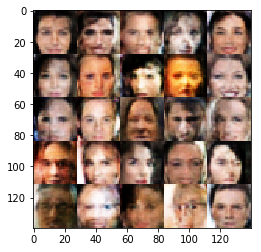

Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 1.2312
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.5784
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 2.2458... Generator Loss: 2.2474
Epoch 1/1... Discriminator Loss: 1.1108... Generator Loss: 1.5284
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 0.9538
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.7402
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.5202


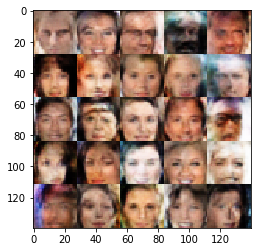

Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.4656
Epoch 1/1... Discriminator Loss: 1.6582... Generator Loss: 0.4189
Epoch 1/1... Discriminator Loss: 0.9129... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 2.0193
Epoch 1/1... Discriminator Loss: 0.8707... Generator Loss: 1.5057
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.5303
Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 1.2939
Epoch 1/1... Discriminator Loss: 0.7950... Generator Loss: 1.2070
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 2.1774


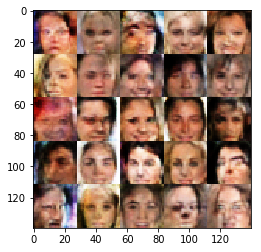

Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 0.8591
Epoch 1/1... Discriminator Loss: 1.0919... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.6410... Generator Loss: 0.4191
Epoch 1/1... Discriminator Loss: 1.2077... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 0.9101... Generator Loss: 0.8880


In [22]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.